In [1]:
# !pip install -q --upgrade scipy
import cv2
import numpy as np
import scipy
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import albumentations as A
import glob
import os
from segmentation_models_pytorch.encoders import get_preprocessing_fn
from tqdm import tqdm
from dataset_cityscapes import *


print(scipy.__version__)

/home/jamada/jupyterlab/eo-xai/xai_fyp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.10.1


In [2]:
# Check if cuda is available
if torch.cuda.is_available():
    print("GPU is available")

# Check if the current device is cuda
if torch.cuda.current_device() == 0:
    print("Current device is cuda:0")

GPU is available
Current device is cuda:0


In [3]:
%cd /home/jamada/jupyterlab/eo-xai/sobol_indices/Sobol-Attribution-Method
!pwd

/home/jamada/jupyterlab/eo-xai/sobol_indices/Sobol-Attribution-Method
/home/jamada/jupyterlab/eo-xai/sobol_indices/Sobol-Attribution-Method


In [4]:
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype("float32")

# ======== CONFIGURATION ======== #
S_NAME_ENCODER = "efficientnet-b4"
S_NAME_WEIGHTS = "imagenet"
P_DIR_MODEL = "/home/jamada/jupyterlab/eo-xai/CityscapesNoiseEfficient-noise1/UNET_EfficientNetB4_CE/utilitybestmodelefficientnet/model_epoch_0050.pth"
P_DIR_DATA = "/home/jamada/jupyterlab/eo-xai/CityScapes_Sementic_Segmentation/datasets/cityscapes/"
S_DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ======== SETUP ======== #
# setup model
model = torch.load(P_DIR_MODEL, map_location=S_DEVICE)
model.eval()
# setup input normalization
preprocess_input = get_preprocessing_fn(
    encoder_name = S_NAME_ENCODER,
    pretrained = S_NAME_WEIGHTS,
)
# play with it! add a transformation to see the generalization performance
transform_weather = A.Compose([
    #A.RandomRain(brightness_coefficient=0.9, blur_value=3, p=1),
    #A.RandomSnow(snow_point_lower=0.3, snow_point_upper=0.5, p=1),
    #A.RandomFog(fog_coef_lower=0.1, fog_coef_upper=0.3, alpha_coef=0.05, p=1),
])
transform_full = A.Compose([
    A.Lambda(name = "image_preprocessing", image = preprocess_input),
    A.Lambda(name = "to_tensor", image = to_tensor),
])
# setup train dataset
dataset_train = DatasetCityscapesSemantic(
    root = P_DIR_DATA,
    split = "train",
    mode = "fine",
    transform = transform_full,
    device= S_DEVICE,
    excluded = [],

)

sem_classes = ['road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
    'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck',
    'bus', 'train', 'motorcycle', 'bicycle', 'background']

sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(sem_classes)}



def show(img, **kwargs):
  if torch.is_tensor(img):
    img = img.detach().cpu().numpy()
    img = np.moveaxis(img, 0, -1)

  img -= img.min(); img /= img.max()
  plt.imshow(img, **kwargs)
  plt.axis('off')
  S_NAME_WEIGHTS = "imagenet"


2975 2975


/home/jamada/jupyterlab/eo-xai/CityScapes_Sementic_Segmentation/datasets/cityscapes/leftImg8bit/train/bremen/bremen_000170_000019_leftImg8bit.png
(1024, 2048)
torch.Size([1, 3, 1024, 2048])


Text(0.5, 1.0, 'Ground Truth')

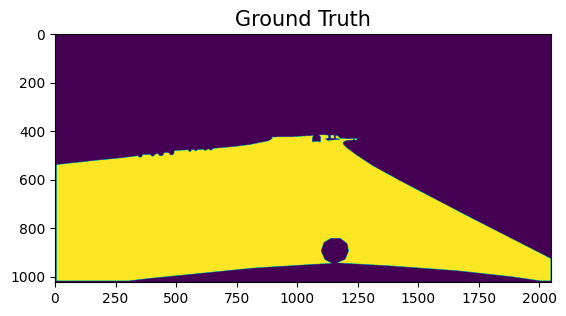

In [5]:
## image setup
im,target,p_image,p_target = dataset_train.__getitem__(4)
print(p_image)
im = torch.tensor(im)
im = im.unsqueeze(0)
x = torch.Tensor(np.array(im)).to(S_DEVICE)
target_all = cv2.imread(p_target,cv2.IMREAD_UNCHANGED) #GT_lableIds
road_mask = (target_all == 7 ).astype(np.uint8)
print(road_mask.shape)
print(im.shape)

#resize
# resize_transform = A.Resize(256,512)
# road_mask = resize_transform(image=road_mask)['image']
plt.imshow(road_mask)
plt.title("Ground Truth", fontsize=15)

In [10]:
target_class_category = 0 # road: 0, sky = 10
#Input_image = x
#Sobol_sm = explanations[i] #(1024,2048)
#CAM_sm = grayscale_cam_EX #(1024,2048)
# Functions:
def prob_2_entropy(prob):
    """ convert probabilistic prediction maps to weighted self-information maps
    """
    n, c, h, w = prob.size()
    return -torch.mul(prob, torch.log2(prob + 1e-30)) / np.log2(c)

def get_mask_entropy(Input_image, Sobol_sm, target_class_category):
    # if Sobol_sm == None:
    if Sobol_sm == None:

        mask_perturbated_sobol = Input_image

    else:

        mask_perturbated_sobol = Input_image  * Sobol_sm # sm: Saliency map

    perturbated_logits_sobol = model(mask_perturbated_sobol)

    # Predicated mask
    prediction_mask_per_sobol = perturbated_logits_sobol.argmax(axis = 1)
    prediction_mask_per_sobol = prediction_mask_per_sobol[0, :, :].detach().cpu().numpy()
    per_mask_uint8_per = 255 * np.uint8(prediction_mask_per_sobol == target_class_category)

    # Entropy masks
    softmax_perturbated_sobol = perturbated_logits_sobol.softmax(axis=1)
    logist_softmax_entropy_perturbated_sobol = prob_2_entropy(softmax_perturbated_sobol)
    target_entropy_mask_perturbated_sobol = logist_softmax_entropy_perturbated_sobol[0, :, :, :].detach().cpu().numpy()
    Entropy_mask_target_class_perturabted = target_entropy_mask_perturbated_sobol[target_class_category, :, :]

    return per_mask_uint8_per, Entropy_mask_target_class_perturabted

def get_mask_entropy_temp(Input_image, Sobol_sm, target_class_category):
    # if Sobol_sm == None:


    mask_perturbated_sobol = Input_image  * Sobol_sm # sm: Saliency map

    perturbated_logits_sobol = model(mask_perturbated_sobol)

    # Predicated mask
    prediction_mask_per_sobol = perturbated_logits_sobol.argmax(axis = 1)
    prediction_mask_per_sobol = prediction_mask_per_sobol[0, :, :].detach().cpu().numpy()
    per_mask_uint8_per = 255 * np.uint8(prediction_mask_per_sobol == target_class_category)

    # Entropy masks
    softmax_perturbated_sobol = perturbated_logits_sobol.softmax(axis=1)
    logist_softmax_entropy_perturbated_sobol = prob_2_entropy(softmax_perturbated_sobol)
    target_entropy_mask_perturbated_sobol = logist_softmax_entropy_perturbated_sobol[0, :, :, :].detach().cpu().numpy()
    Entropy_mask_target_class_perturabted = target_entropy_mask_perturbated_sobol[target_class_category, :, :]

    return per_mask_uint8_per, Entropy_mask_target_class_perturabted

In [11]:
#Model Input: input image
[predicted_mask, entropy_mask]=get_mask_entropy(x,None,0)

Text(0.5, 1.0, 'Predicted Mask')

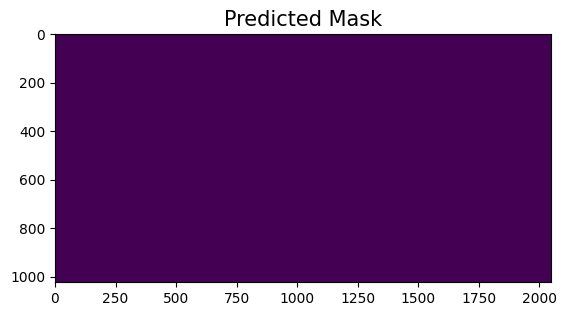

In [12]:
plt.imshow(predicted_mask)
plt.title("Predicted Mask", fontsize=15)

Text(0.5, 1.0, 'Entropy Mask')

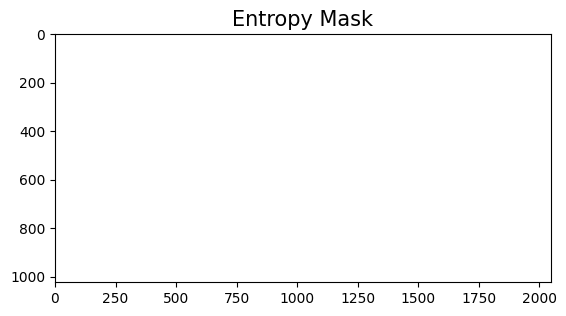

In [43]:
plt.imshow(entropy_mask)
plt.title("Entropy Mask",fontsize=15 )

In [6]:
from sobol_attribution_method.torch_explainer import SobolAttributionMethod

In [7]:
explainer = SobolAttributionMethod(model,road_mask, grid_size=8, nb_design=32, batch_size=8)
print(x.shape)
explanations = explainer(x)

# print(y)

for i in range(len(x)):
    plt.subplot(1, len(x), i+1)
    # show(x[i].cpu())
    show(explanations[i], cmap='jet', alpha=0.5)
    print(explanations[i].max(),explanations[i].min())
plt.show()

masks:  (2112, 1, 8, 8)
torch.Size([1, 3, 1024, 2048])


RuntimeError: CUDA out of memory. Tried to allocate 2.25 GiB (GPU 0; 11.91 GiB total capacity; 9.57 GiB already allocated; 1.57 GiB free; 9.58 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF